In [477]:
import dotenv
import os

dotenv.load_dotenv()
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List, Tuple

import random
import numpy

In [478]:
from utils.frameReader import FrameReader
from utils.predictor import GVLPredictor
from utils.visualiser import GVLVisualizer
from utils.vlm import ClaudeVLM, OpenAIVLM, GeminiVLM

In [479]:
order = 'unshuffled'


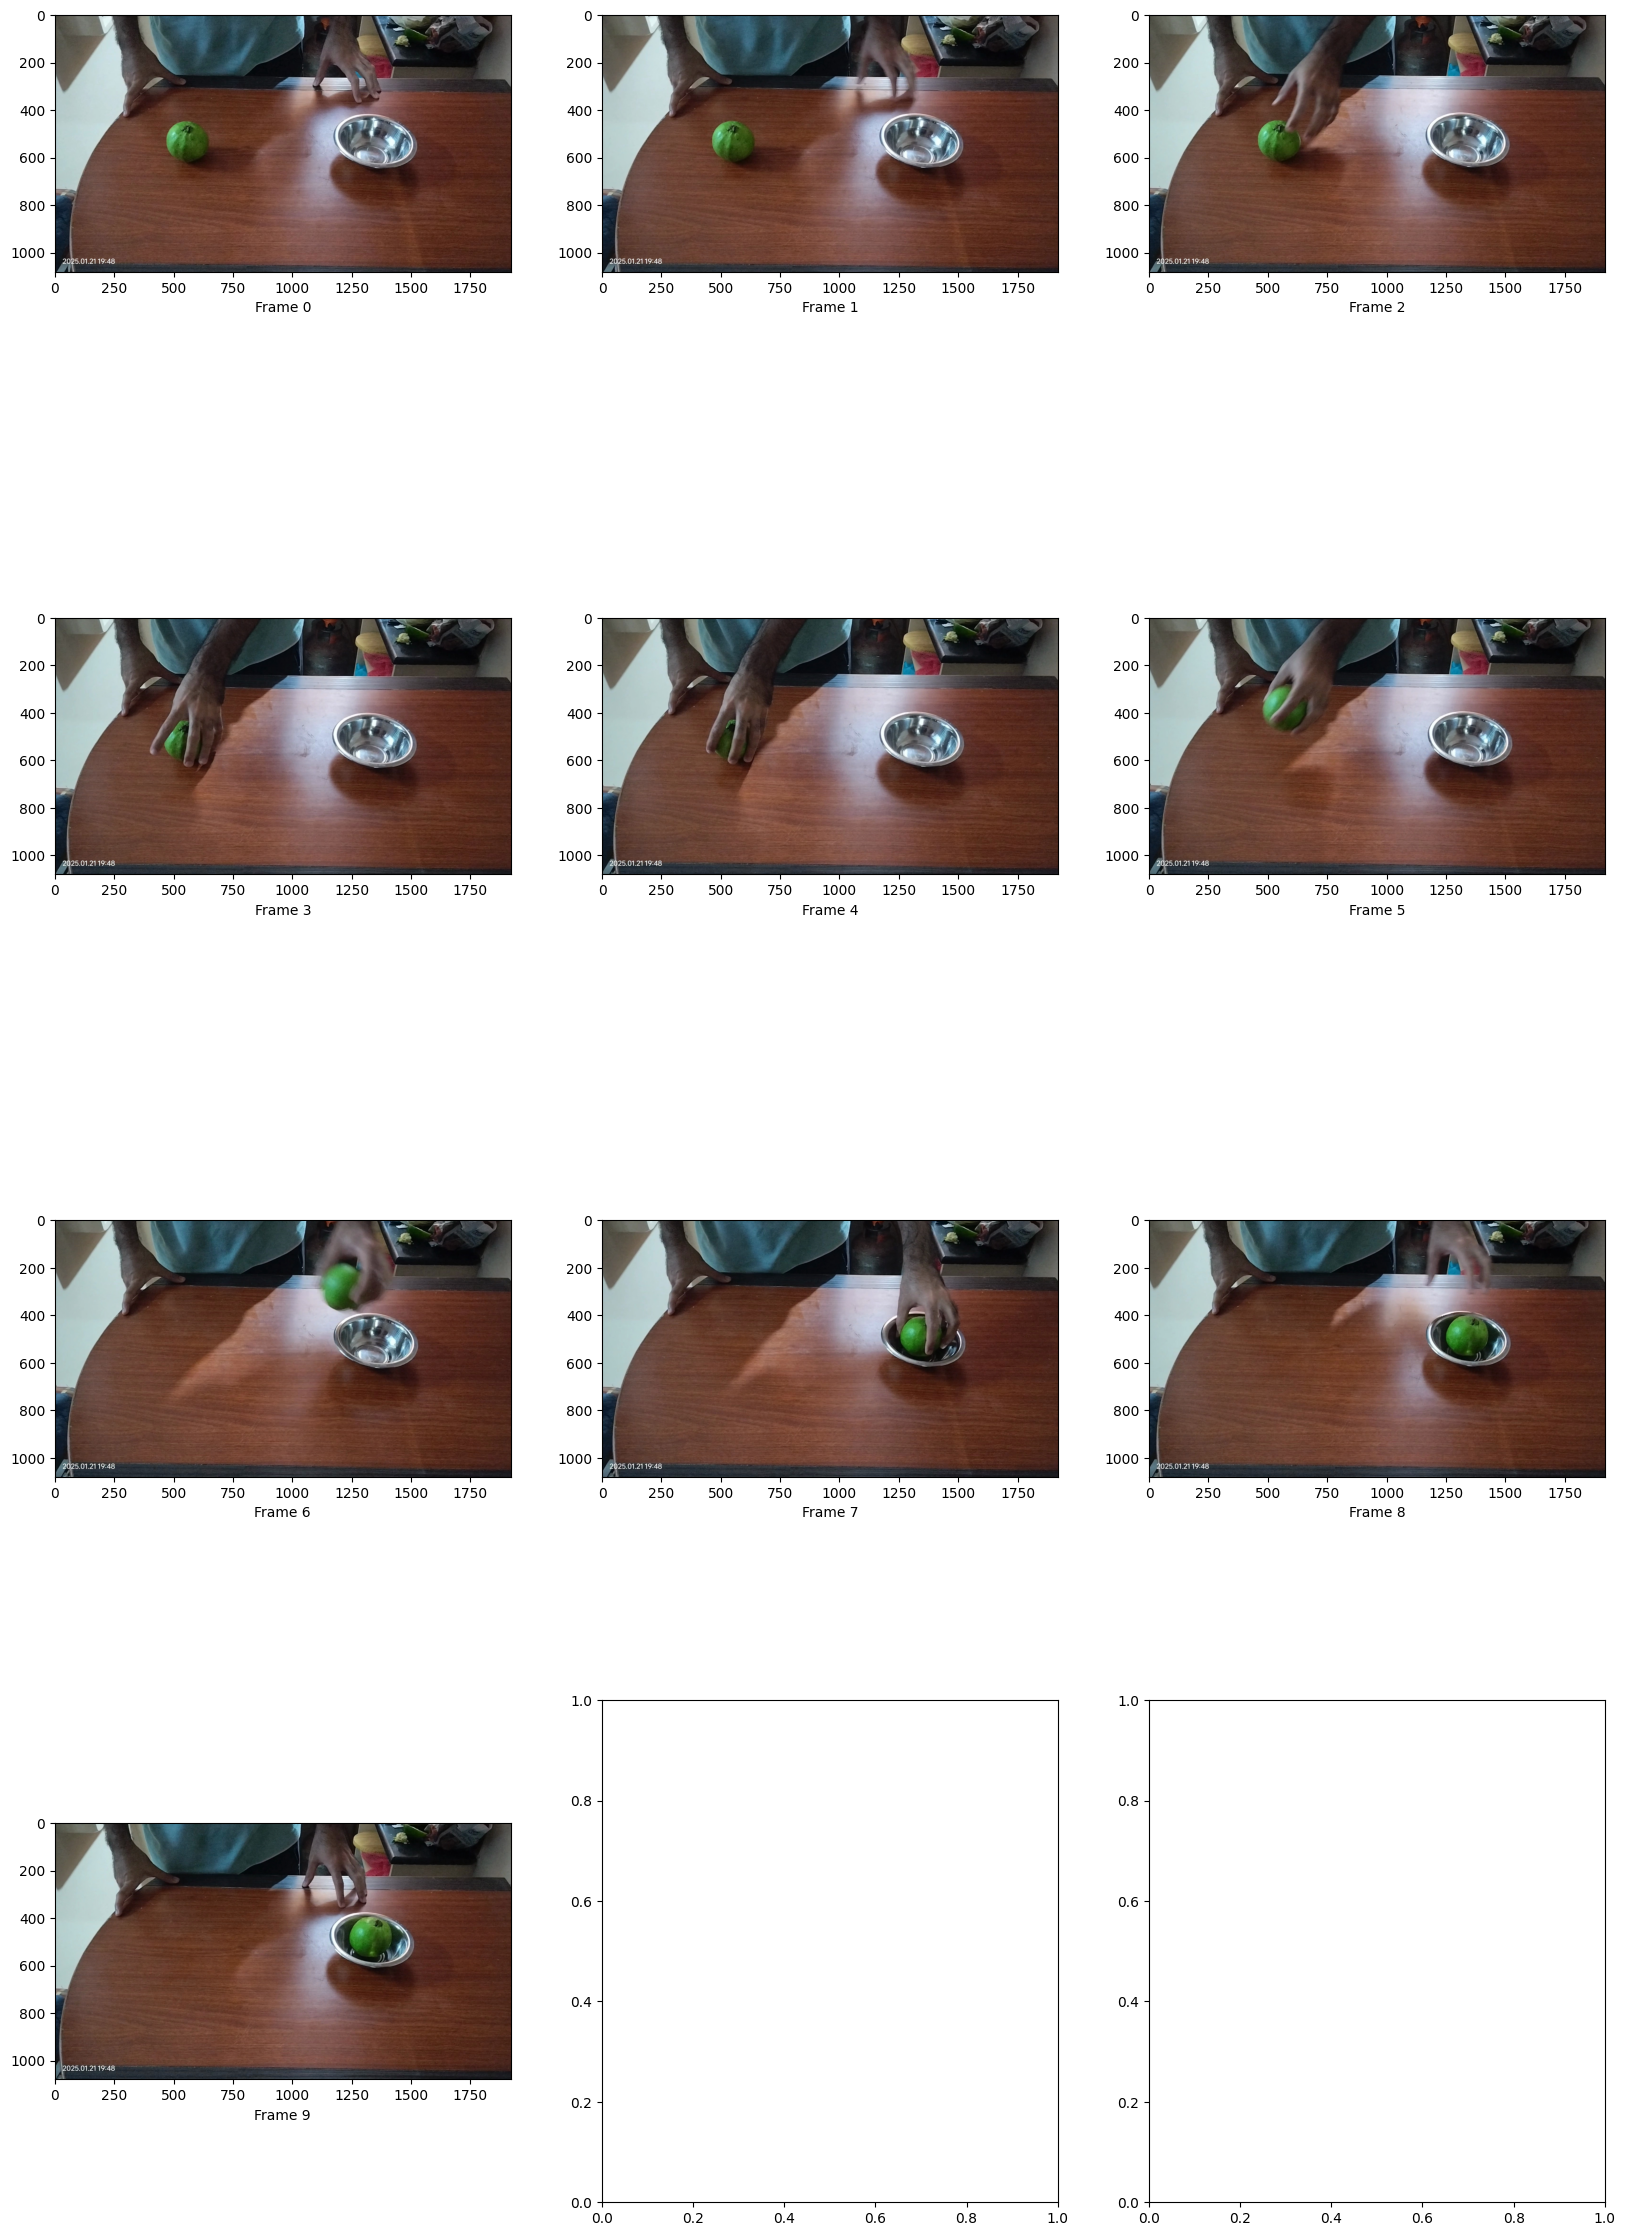

In [480]:
image_columns = 3

# Read frames
frames_dir = "data/frames/fruit_success_4"
frames = FrameReader.read_frames_from_dir(frames_dir)

num_frames = len(frames)
fig, ax = plt.subplots(num_frames//image_columns + 1, image_columns, figsize=(20, 30))
c = 0
for i, ix in enumerate(frames):
    ax[c//image_columns][c%image_columns].imshow(ix)
    #set x label
    ax[c//image_columns][c%image_columns].set_xlabel(f"Frame {i}")

    c+=1

In [481]:
def shuffle_frames(
    frames: List, keep_first: bool = True
) -> Tuple[List, List]:
    """Shuffle frames while optionally keeping first frame fixed."""
    if keep_first:
        first_frame = frames[0]
        remaining_frames = frames[1:]
        shuffled_indices = list(range(1, len(frames)))
        random.shuffle(shuffled_indices)

        shuffled_frames = [first_frame] + [frames[i] for i in shuffled_indices]
        indices = [0] + shuffled_indices
    else:
        shuffled_indices = list(range(len(frames)))
        random.shuffle(shuffled_indices)
        shuffled_frames = [frames[i] for i in shuffled_indices]
        indices = shuffled_indices

    return shuffled_frames, indices

In [482]:
# shuffled_frames, indices = shuffle_frames(frames)
shuffled_frames = frames


In [483]:
# fig, ax = plt.subplots(num_frames//image_columns + 1, image_columns, figsize=(20, 30))
# c = 0
# for i, ix in enumerate(shuffled_frames):
#     ax[c//image_columns][c%image_columns].imshow(ix)
#     #set x label
#     ax[c//image_columns][c%image_columns].set_xlabel(f"Frame {i}")

#     c+=1

In [484]:
import io

In [485]:
import base64

import google.generativeai as genai
from IPython.display import Markdown
from PIL import Image

# Assuming you have the following:
# - list_pil_images: list of PIL images
# - list_base64_images: list of base64 encoded strings of the images
# - task_description: string describing the task

# Prepare the prompt with the task description
prompt_template = """
You are an expert roboticist tasked to predict task completion percentages for frames of a robot for the task of {task_description}. You are given {num_frames} frames.
The task completion percentages are between 0 and 100, where 100 corresponds to full task completion. Note that these frames are in random order, so please pay attention to the individual frames when reasoning about task completion percentage.
Initial robot scene: [IMG]
In the initial robot scene, the task completion percentage is 0.

Here is an example run which was a success, and its tas k compeltion percentages
Frame 1: img: %
...
...
Frame n: img: %

Now, for the task of {task_description}, output the task completion percentage for the following frames that are presented in random order. For each frame, format your response as follow: 
Frame [i]: Frame Description: [], Task Completion Percentages:[]%
Frame [1]: [IMG]
...
Frame [n]: [IMG]
"""


In [486]:
task_description = "lift the fruit from the table and keep it in the bowl"

In [487]:
def image_to_base64(image: Image.Image, format="JPEG") -> str:
    buffer = io.BytesIO()
    image.save(buffer, format=format)
    img_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return img_str


In [488]:
correct_order = [i for i in range(len(frames))]

In [489]:
# shuffled_frames = frames if order =='unshuffled' else shuffled_frames

In [490]:
list_base64_images = [image_to_base64(Image.fromarray(numpy.array(ix))) for ix in shuffled_frames]

In [491]:
key = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=key)
model = genai.GenerativeModel(model_name="gemini-2.0-flash-exp")


In [492]:
prompt = prompt_template.format(task_description=task_description, num_frames=len(frames))

In [493]:
print(prompt)


You are an expert roboticist tasked to predict task completion percentages for frames of a robot for the task of lift the fruit from the table and keep it in the bowl. You are given 10 frames.
The task completion percentages are between 0 and 100, where 100 corresponds to full task completion. Note that these frames are in random order, so please pay attention to the individual frames when reasoning about task completion percentage.
Initial robot scene: [IMG]
In the initial robot scene, the task completion percentage is 0.

Here is an example run which was a success, and its tas k compeltion percentages
Frame 1: img: %
...
...
Frame n: img: %

Now, for the task of lift the fruit from the table and keep it in the bowl, output the task completion percentage for the following frames that are presented in random order. For each frame, format your response as follow: 
Frame [i]: Frame Description: [], Task Completion Percentages:[]%
Frame [1]: [IMG]
...
Frame [n]: [IMG]



In [494]:
import typing_extensions as typing

class TaskProgress(typing.TypedDict):
    frame_n: int
    discription: str
    completion_percentage: int

In [495]:
len(list_base64_images)

10

In [496]:
# Prepare the list of images for the LLM
images_for_llm = []
for base64_image in list_base64_images:
    image_dict = {
        'mime_type': 'image/jpeg',  # Adjust MIME type if necessary
        'data': base64_image
    }
    images_for_llm.append(image_dict)

# Insert the initial scene image at the beginning
# initial_image_base64 = list_base64_images[0]  # Assuming the first image is the initial scene
# images_for_llm.insert(0, {
#     'mime_type': 'image/jpeg',
#     'data': initial_image_base64
# })

generation_config={"response_mime_type": "application/json",
                   "response_schema": list[TaskProgress]}

print(f"sending {len(images_for_llm)} images to the model")

# Generate content using the model
response = model.generate_content([prompt] + images_for_llm)

# Print the response
print(response.text)

sending 10 images to the model
Okay, I will analyze each frame and provide the task completion percentage.

Frame 1: Frame Description: [The fruit and bowl are on the table, hands are near the fruit but not touching it.], Task Completion Percentages:[0]%
Frame 2: Frame Description: [The fruit and bowl are on the table, hands are near the fruit but not touching it.], Task Completion Percentages:[0]%
Frame 3: Frame Description: [The fruit and bowl are on the table, hands are touching the fruit.], Task Completion Percentages:[15]%
Frame 4: Frame Description: [The fruit is being touched by the hand, starting to be lifted], Task Completion Percentages:[30]%
Frame 5: Frame Description: [The fruit is being lifted from the table.], Task Completion Percentages:[50]%
Frame 6: Frame Description: [The fruit is being lifted from the table towards the bowl.], Task Completion Percentages:[60]%
Frame 7: Frame Description: [The fruit is above the bowl.], Task Completion Percentages:[75]%
Frame 8: Frame

In [497]:
import json

lines = response.text.strip().split('\n')

frames_output = []

for line in lines:
    if line.startswith('Frame '):
        # Extract frame number
        frame_no = int(line.split(':')[0].split(' ')[1])
        # Extract description
        description_start = line.find('Frame Description: [') + len('Frame Description: [')
        description_end = line.find('], Task Completion Percentages:')
        description = line[description_start:description_end]
        # Extract percentage
        percentage_start = line.find('Task Completion Percentages:[') + len('Task Completion Percentages:[')
        percentage_end = line.find(']%', percentage_start)
        percentage = int(line[percentage_start:percentage_end])
        # Create dictionary and append to list
        frame = {
            "frame_no": frame_no,
            "description": description,
            "percentage": percentage
        }
        frames_output.append(frame)

# Convert to JSON
json_output = json.dumps(frames_output, indent=4)
print(json_output)

[
    {
        "frame_no": 1,
        "description": "The fruit and bowl are on the table, hands are near the fruit but not touching it.",
        "percentage": 0
    },
    {
        "frame_no": 2,
        "description": "The fruit and bowl are on the table, hands are near the fruit but not touching it.",
        "percentage": 0
    },
    {
        "frame_no": 3,
        "description": "The fruit and bowl are on the table, hands are touching the fruit.",
        "percentage": 15
    },
    {
        "frame_no": 4,
        "description": "The fruit is being touched by the hand, starting to be lifted",
        "percentage": 30
    },
    {
        "frame_no": 5,
        "description": "The fruit is being lifted from the table.",
        "percentage": 50
    },
    {
        "frame_no": 6,
        "description": "The fruit is being lifted from the table towards the bowl.",
        "percentage": 60
    },
    {
        "frame_no": 7,
        "description": "The fruit is above the bowl."

In [498]:
#lambda function for descriptions
#add \n after every nth character in description
add_newline = lambda x, n: '\n'.join([x[i:i+n] for i in range(0, len(x), n)])



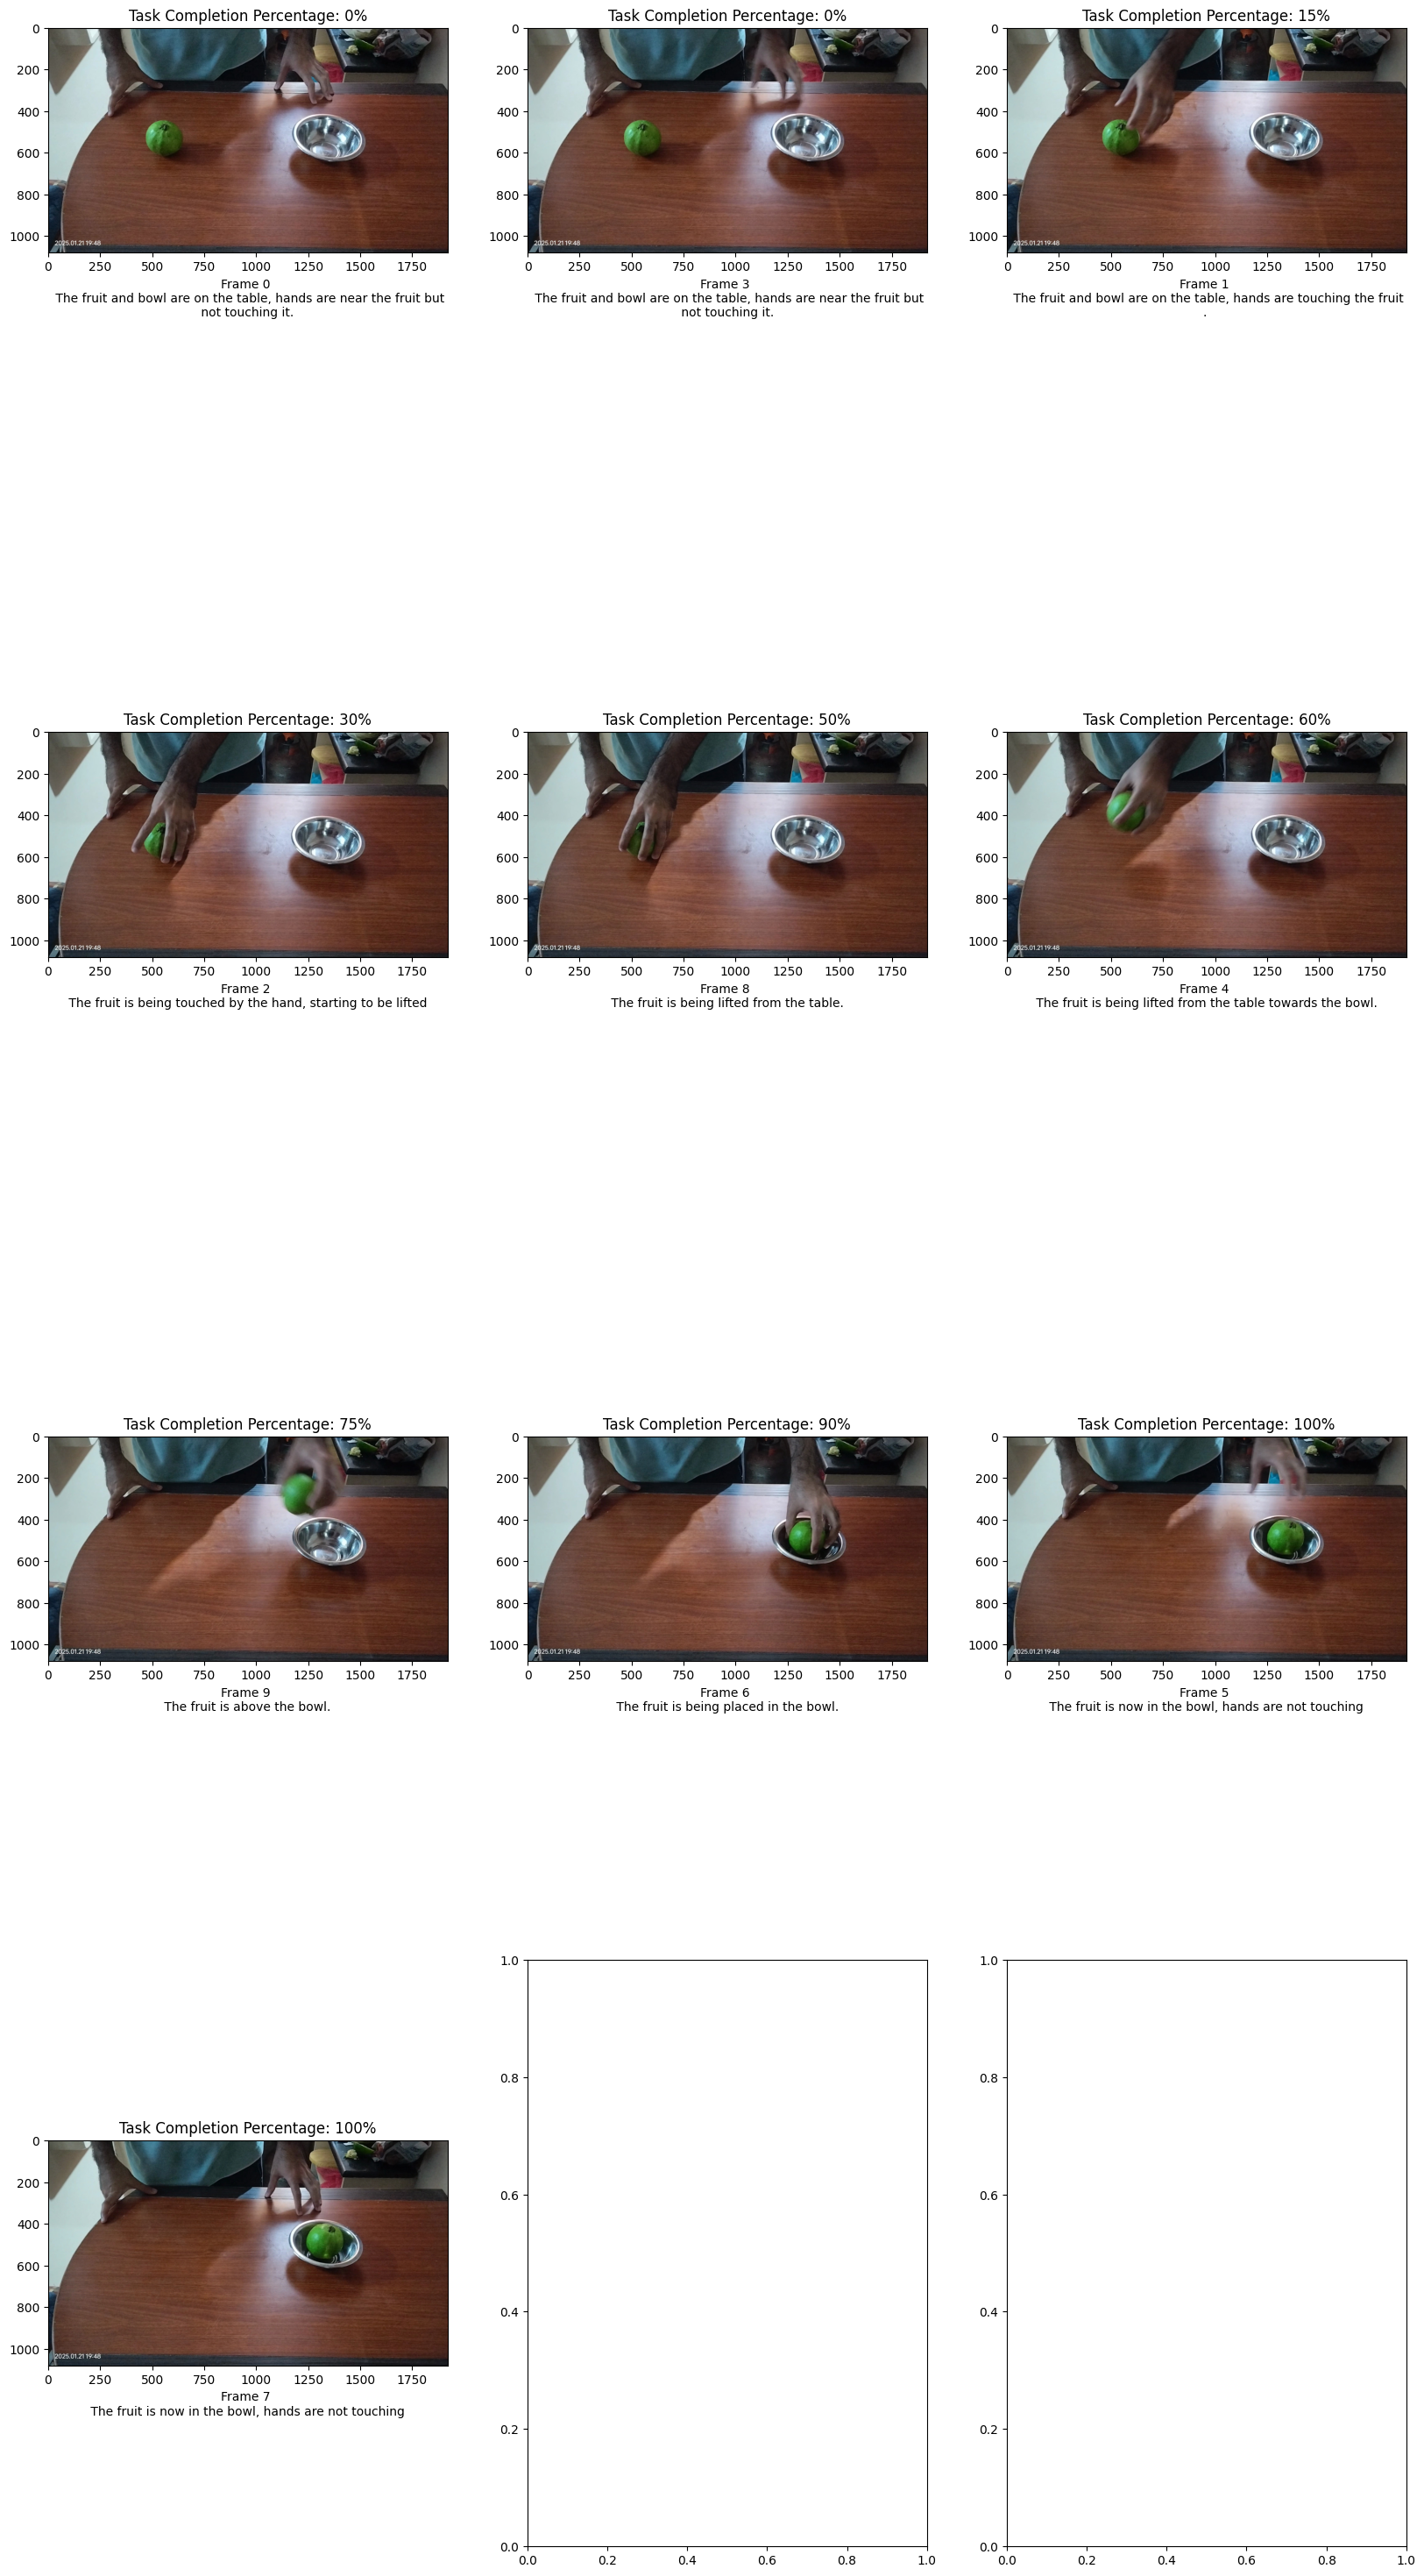

In [499]:
fig, ax = plt.subplots(num_frames//image_columns + 1, image_columns, figsize=(20, 40))
c = 0
for i, (image, indice, json_obj) in enumerate(zip(shuffled_frames, indices, frames_output)):
    ax[c//image_columns][c%image_columns].imshow(image)
    #set x label
    ax[c//image_columns][c%image_columns].set_xlabel(f"Frame {indice} \n {add_newline(json_obj['description'], 65)} \n")
    
    ax[c//image_columns][c%image_columns].title.set_text(f"Task Completion Percentage: {json_obj['percentage']}%")
    c+=1

In [500]:
import pandas as pd


df = pd.DataFrame(frames_output)
df['true_frame'] = indices if order == 'shuffled' else df['frame_no']
df

frame_no                                        description  percentage  \
0         1  The fruit and bowl are on the table, hands are...           0   
1         2  The fruit and bowl are on the table, hands are...           0   
2         3  The fruit and bowl are on the table, hands are...          15   
3         4  The fruit is being touched by the hand, starti...          30   
4         5          The fruit is being lifted from the table.          50   
5         6  The fruit is being lifted from the table towar...          60   
6         7                       The fruit is above the bowl.          75   
7         8             The fruit is being placed in the bowl.          90   
8         9  The fruit is now in the bowl, hands are not to...         100   
9        10  The fruit is now in the bowl, hands are not to...         100   

   true_frame  
0           1  
1           2  
2           3  
3           4  
4           5  
5           6  
6           7  
7           8  
8           9  
9          10

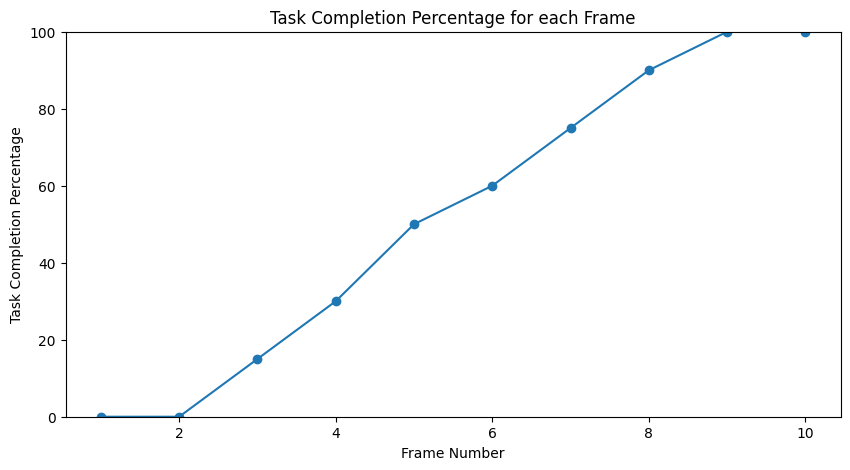

In [501]:
frame_percentage = [(row['true_frame'], row['percentage']) for index, row in df.iterrows()]
frame_percentage.sort(key=lambda x: x[0])

#create line plot with markers
plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in frame_percentage], [x[1] for x in frame_percentage], marker='o')
plt.ylim(0, 100)
plt.xlabel('Frame Number')
plt.ylabel('Task Completion Percentage')
plt.title('Task Completion Percentage for each Frame')
plt.show()